# Plots of state occupancy (with residual scores :) )

The idea - 4-quadrant plot:
- top-left raw scatter plot
- top-right uniform bins
- bottom-left tree bins
- bottom-right nn - residual scores + gradient

In [137]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from crl.utils.graphing import despine

from ccnn import calibrate_ccnn
from crl.cons.calib import collect_transitions, signed_score
from crl.cons.agents import learn_dqn_policy

In [145]:
def plot_obs_scatter(
    scores: np.ndarray,
    features: np.ndarray,
    ax: plt.Axes | None = None,
    x: int = 0,
    y: int = 1,
    xlabel: str | None = None,
    ylabel: str | None = None,
    alpha: float = 0.25,
    per_point_max_dists: np.ndarray | None = None,
    max_dist: float | None = None,
    s: int = 2,
    cbar: bool = True
) -> None:
    cmap = "viridis"
    norm = mpl.colors.Normalize(vmin=float(np.min(scores)), vmax=float(np.max(scores)))

    xs = features[:, x]
    ys = features[:, y]

    if ax is None:
        fig, ax = plt.subplots(1, 1)

    if per_point_max_dists is not None and max_dist is not None:
        mask = np.asarray(per_point_max_dists) > max_dist

        if np.any(~mask):
            ax.scatter(
                xs[~mask],
                ys[~mask],
                c=scores[~mask],
                cmap=cmap,
                norm=norm,
                alpha=alpha,
                s=s,
                marker="o",
            )
        if np.any(mask):
            ax.scatter(
                xs[mask],
                ys[mask],
                c="red",
                cmap=cmap,
                norm=norm,
                alpha=1.0,
                s=s,
                marker="o",
            )
    else:
        ax.scatter(xs, ys, c=scores, cmap=cmap, norm=norm, alpha=alpha, s=s)

    mappable = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
    if cbar:
        fig.colorbar(mappable, ax=ax, label="score")
    ax.set_xlabel(xlabel or f"dim: {x}")
    ax.set_ylabel(ylabel or f"dim: {y}")
    despine(ax)
    return mappable

parameter_names = {
    "Acrobot-v1": [
        r"$\cos(\theta_1)$",
        r"$\sin(\theta_1)$",
        r"$\cos(\theta_2)$",
        r"$\sin(\theta_2)$",
        r"$\omega_1$",
        r"$\omega_2$",
    ],
    "CartPole-v1": ["Cart Position", "Cart Velocity", r"$\theta$", r"$\omega$"],
    "MountainCar-v0": ["position", "velocity"],
    "LunarLander-v3": [
        r"$x$",
        r"$y$",
        r"$v_x$",
        r"$v_y$",
        r"$\theta$",
        r"$\omega$",
        "Left contact",
        "Right contact",
    ],
}

In [151]:
env_name = "CartPole-v1"

results = []
for seed in [1, 3, 5, 6]:
    model, vec_env = learn_dqn_policy(env_name=env_name, seed=seed, model_dir="models")
    buffer = collect_transitions(model, vec_env, 5_000)
    scores, scaler, tree, max_dist = calibrate_ccnn(
        model,
        buffer,
        k=50,
        score_fn=signed_score,
        scoring_method="td",
    )

    state_features, action_features = (
        np.array(tree.data)[:, :-1],
        np.array(tree.data)[:, -1],
    )
    results.append((scores, state_features))

Loading model: 1
Loading model: 3
Loading model: 5
Loading model: 6


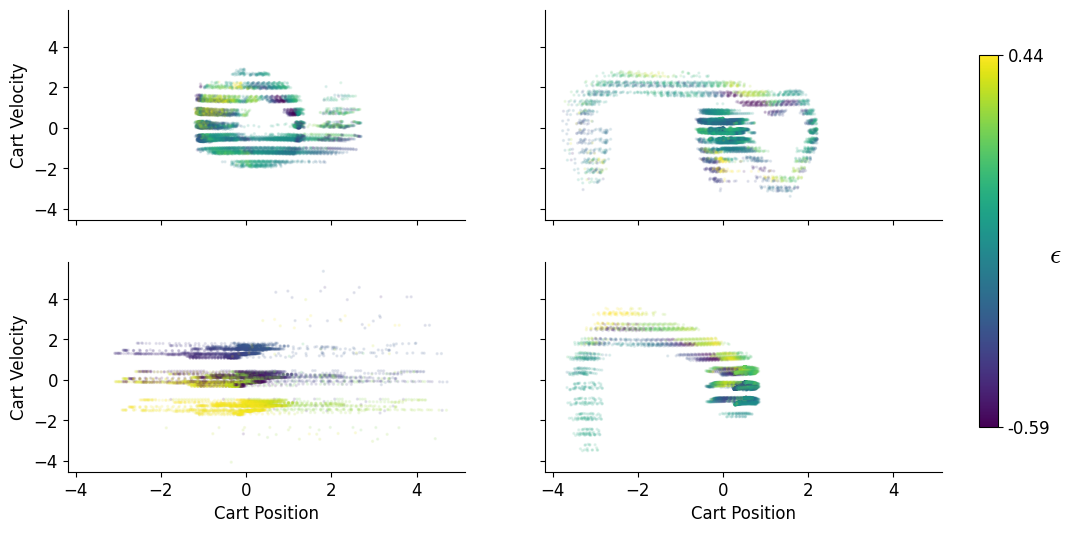

In [155]:
x_ix = 0
y_ix = 1
env_param_names = parameter_names[env_name]
xlabel, ylabel = env_param_names[x_ix], env_param_names[y_ix]
plt.rcParams["mathtext.fontset"] = "cm"
plt.rcParams['font.size']= 12

fig, axes = plt.subplots(2, 2, figsize=(12, 6), sharex=True, sharey=True)
for ix, (scores, features) in enumerate(results):
    row, col = divmod(ix, 2)
    mappable = plot_obs_scatter(
        scores,
        features,
        ax=axes[row, col],
        x=x_ix,
        y=y_ix,
        xlabel=xlabel,
        ylabel=ylabel,
        alpha=0.1,
        s=2,
        cbar=False
    )

axes[0, 0].set_xlabel(None)
axes[1, 1].set_ylabel(None)
axes[0, 1].set_ylabel(None)
axes[0, 1].set_xlabel(None)

# Add one shared colorbar to the right
cbar = fig.colorbar(mappable, ax=axes, orientation='vertical', fraction=0.02, pad=0.04)
# Set ticks to min and max only
vmin, vmax = mappable.norm.vmin, mappable.norm.vmax
cbar.set_ticks([vmin, vmax], labels=[f'{vmin:.2f}', f'{vmax:.2f}'])
cbar.set_label(r"$\epsilon$", rotation=0, fontsize=20, loc='center')
# cbar.set_label(r"$Q(s,a) - [r + \max_{a'} Q(s', a')]$", rotation=90, fontsize=16, loc='center')

# plt.tight_layout()
plt.savefig('../../results/figures/state_occupancy/cartpole_state_occupancy.pdf', bbox_inches='tight')
plt.savefig('../../results/figures/state_occupancy/cartpole_state_occupancy.png', bbox_inches='tight')
plt.show()